In [246]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import nbformat
from datetime import datetime, date, time, timedelta
import missingno as msno

# Clean Data

In [247]:
df_kc =  pd.read_csv("data/king_county_data.csv")
df_kc.head(2)

,Unnamed: 0,date,price,house_id,id_x,id_y,bedrooms,bathrooms,sqft_living,sqft_lot,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2014-10-13,221900.0,7129300520,1,7129300520,3.0,1.00,1180.0,5650.0,...,7,1180.0,0.0,1955,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,1,2014-12-09,538000.0,6414100192,2,6414100192,3.0,2.25,2570.0,7242.0,...,7,2170.0,400.0,1951,19910.0,98125,47.7210,-122.319,1690.0,7639.0


In [248]:
df_kc.drop(["Unnamed: 0", "id_x", "id_y"], axis=1, inplace=True)
df_kc.columns

Index(['date', 'price', 'house_id', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [249]:
#reorder columns
df_kc = df_kc[['house_id', 'date', 'price', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15']]

In [250]:
df_kc.duplicated().sum()

np.int64(0)

In [251]:
df_kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_id       21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  float64
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     19206 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21145 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17749 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [252]:
df_kc['date'] = pd.to_datetime(df_kc['date'], format='%Y-%m-%d')

In [253]:
df_kc['bedrooms'] = df_kc['bedrooms'].astype(int)
df_kc['bathrooms'] = df_kc['bathrooms'].astype(int)
df_kc['floors'] = df_kc['floors'].astype(int)
df_kc["condition"] = df_kc["condition"].astype(int)
df_kc['yr_renovated'] = df_kc['yr_renovated']/10 #Corrected error in data

In [254]:
df_kc['yr_renovated'] = df_kc['yr_renovated'].fillna(0).astype(int) 
df_kc['sqft_basement'] = df_kc['sqft_basement'].fillna(0).astype(int) # Assuming NaN == no basement
df_kc['waterfront'] = df_kc['waterfront'].fillna(2).astype(int) # Will save NaN as "2" just in case it's useful later, as I could double check that in a map if needed
df_kc['view'] = df_kc['view'].fillna(2).astype(int) # same for now, maybe I drop them later as there are only 63 nan

In [255]:
df_kc.isna().sum()

house_id         0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# EDA


> **Goal**: 
> 
> Identify **undervalued properties** in **poor neighborhoods** with **high potential for resale value growth post-renovation**. 


## Hosing Prices Distribution

In [256]:
df_kc_locations = df_kc[["house_id", "lat", "long"]]
df_kc_locations.head()

,house_id,lat,long
0,7129300520,47.5112,-122.257
1,6414100192,47.7210,-122.319
2,5631500400,47.7379,-122.233
3,2487200875,47.5208,-122.393
4,1954400510,47.6168,-122.045


In [257]:
price_bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]
price_labels = [f"{int(price_bins[i]/1000)}K-{int(price_bins[i+1]/1000)}K" for i in range(len(price_bins)-1)]
df_kc['price_range'] = pd.cut(df_kc['price'], bins=price_bins, labels=price_labels)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '0K-100K'),
  Text(1, 0, '100K-200K'),
  Text(2, 0, '200K-300K'),
  Text(3, 0, '300K-400K'),
  Text(4, 0, '400K-500K'),
  Text(5, 0, '500K-600K'),
  Text(6, 0, '600K-700K'),
  Text(7, 0, '700K-800K'),
  Text(8, 0, '800K-900K'),
  Text(9, 0, '900K-1000K')])

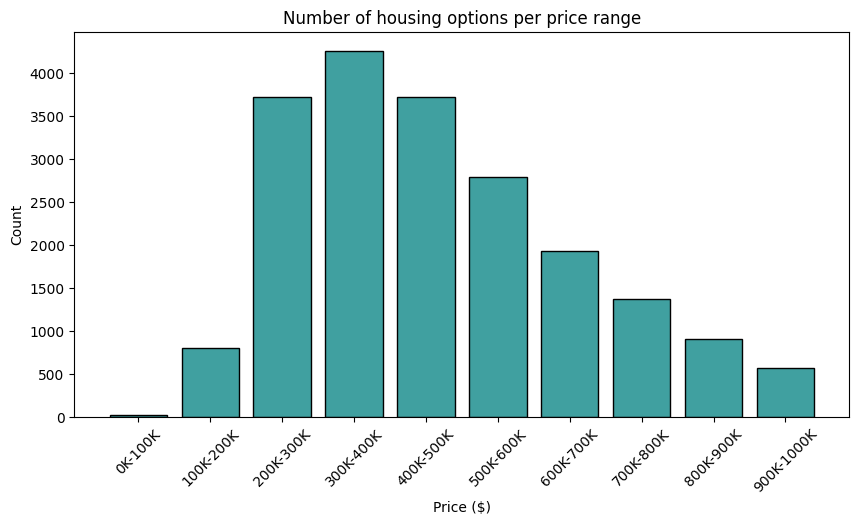

In [258]:
plt.figure(figsize=(10, 5))
sns.histplot(df_kc["price_range"], discrete=True, color = "teal", shrink=0.8)
plt.title("Number of housing options per price range")
plt.xlabel("Price ($)")
plt.xticks(rotation=45)

In [259]:
df_kc.columns

Index(['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_range'],
      dtype='object')

In [260]:
df_kc["zipcode"].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [261]:
poor_seattle = [98108, 98106, 98125, 98115, 98118, 98144, 98126] #from an internet research (see documentation)
df_kc_target = df_kc[df_kc["zipcode"].isin(poor_seattle)]
df_kc_target["zipcode"].unique()

array([98125, 98115, 98126, 98144, 98118, 98108, 98106])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '0K-100K'),
  Text(1, 0, '100K-200K'),
  Text(2, 0, '200K-300K'),
  Text(3, 0, '300K-400K'),
  Text(4, 0, '400K-500K'),
  Text(5, 0, '500K-600K'),
  Text(6, 0, '600K-700K'),
  Text(7, 0, '700K-800K'),
  Text(8, 0, '800K-900K'),
  Text(9, 0, '900K-1000K')])

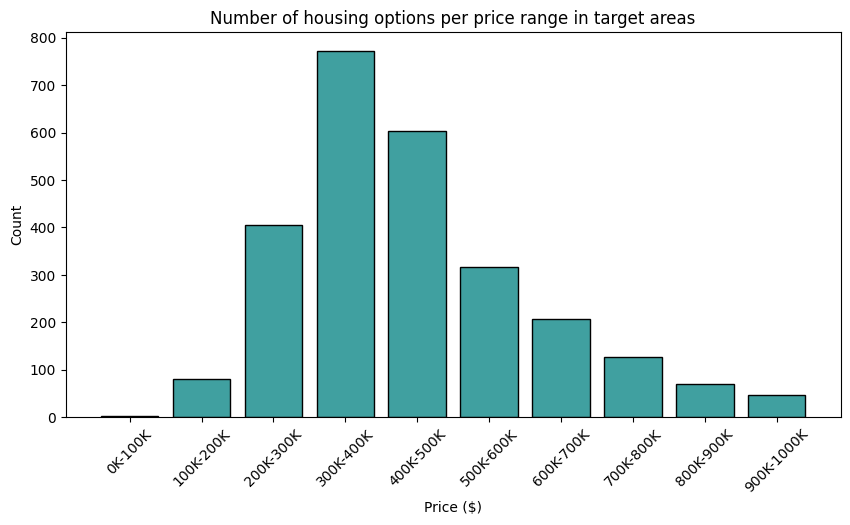

In [262]:
#interesting to see that actually poor neighbourhoods don't mean lower prices on houses
plt.figure(figsize=(10, 5))
sns.histplot(df_kc_target["price_range"], discrete=True, color = "teal", shrink=0.8)
plt.title("Number of housing options per price range in target areas")
plt.xlabel("Price ($)")
plt.xticks(rotation=45)

## Evaluate Outliers
> remove overly expensive housing options

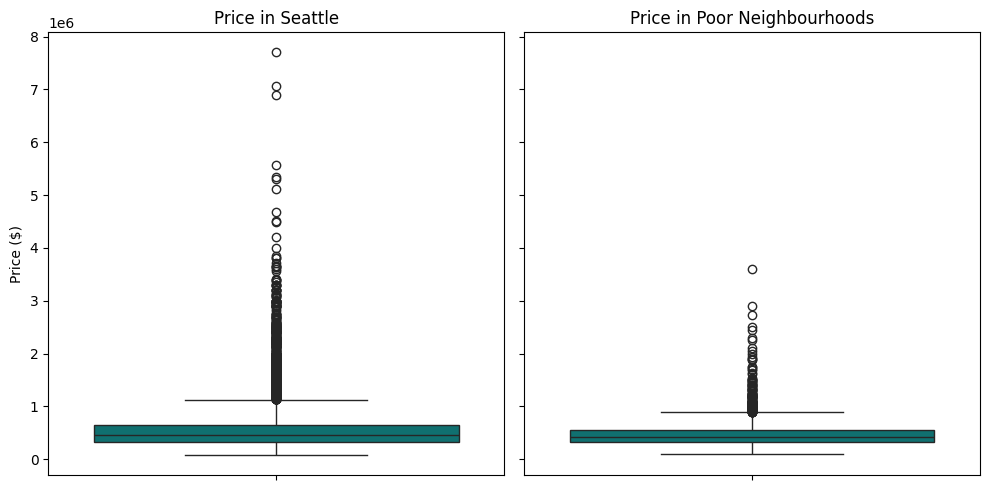

In [263]:
# Function to format y-axis labels with thousands separators
def format_labels(x, pos):
    return f'{int(x):,}'

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the boxplots
sns.boxplot(y=df_kc["price"], ax=ax[0], color="teal")
sns.boxplot(y=df_kc_target["price"], ax=ax[1], color="teal")

# Set titles
ax[0].set_title('Price in Seattle')
ax[1].set_title('Price in Poor Neighbourhoods')

# Set y-axis label for both subplots
ax[0].set_ylabel("Price ($)")
ax[1].set_ylabel("Price ($)")

# Adjust layout to make it look nice
plt.ylabel("Price ($)")
plt.tight_layout()

# Show plot
plt.show()


In [264]:
stats = df_kc_target["price"].describe()
Q1 = stats['25%']
Q2 = stats['50%']
Q3 = stats['75%']
IQR = Q3 - Q1
lower_whisker = max(df_kc_target.price[df_kc_target.price >= (Q1 - 1.5 * IQR)].min(), df_kc_target.price.min())
upper_whisker = min(df_kc_target.price[df_kc_target.price <= (Q3 + 1.5 * IQR)].max(), df_kc_target.price.max())
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

Lower Whisker: 90000.0
Upper Whisker: 885000.0


In [265]:
#cleaned from outliers
df_kc_target = df_kc_target.query("price <= 885000")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '0K-100K'),
  Text(1, 0, '100K-200K'),
  Text(2, 0, '200K-300K'),
  Text(3, 0, '300K-400K'),
  Text(4, 0, '400K-500K'),
  Text(5, 0, '500K-600K'),
  Text(6, 0, '600K-700K'),
  Text(7, 0, '700K-800K'),
  Text(8, 0, '800K-900K'),
  Text(9, 0, '900K-1000K')])

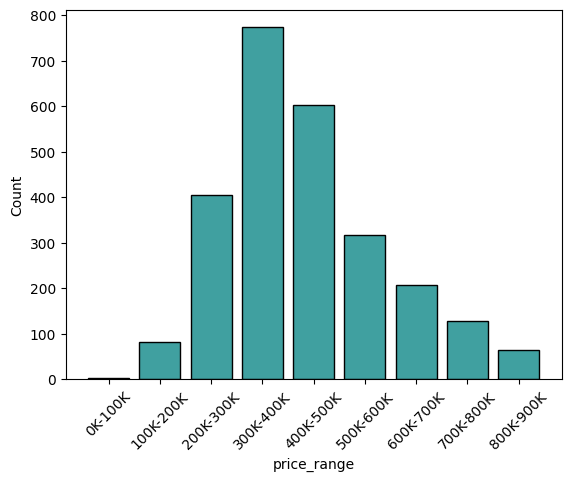

In [266]:
sns.histplot(df_kc_target["price_range"], color = "teal", shrink = 0.8)
plt.xticks(rotation=45)

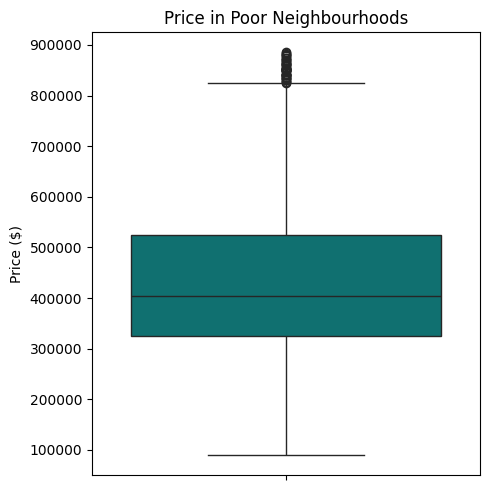

In [267]:
# Function to format y-axis labels with thousands separators
def format_labels(x, pos):
    return f'{int(x):,}'

# Create subplots
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(y=df_kc_target["price"], color="teal")

# Set titles
ax.set_title('Price in Poor Neighbourhoods')

# Set y-axis label for both subplots
ax.set_ylabel("Price ($)")

# Adjust layout to make it look nice
plt.ylabel("Price ($)")
plt.tight_layout()

# Show plot
plt.show()


## Evaluate Housing Value

In [268]:
df_kc_target.columns

Index(['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_range'],
      dtype='object')

In [269]:
# Remove waterfront, yr_build, floors, sqft_lot15, sqft_lot, as they don't seem to have influece on pricce in these target neighbourhoods
df_kc_target = df_kc_target[['house_id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement','zipcode',
       'lat', 'long', 'sqft_living15', 'yr_renovated', 'price_range']]

In [270]:
df_kc_target_corr = df_kc_target[[ 'bedrooms', 'bathrooms', 'sqft_living',
      'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'price']].corr()

<Axes: >

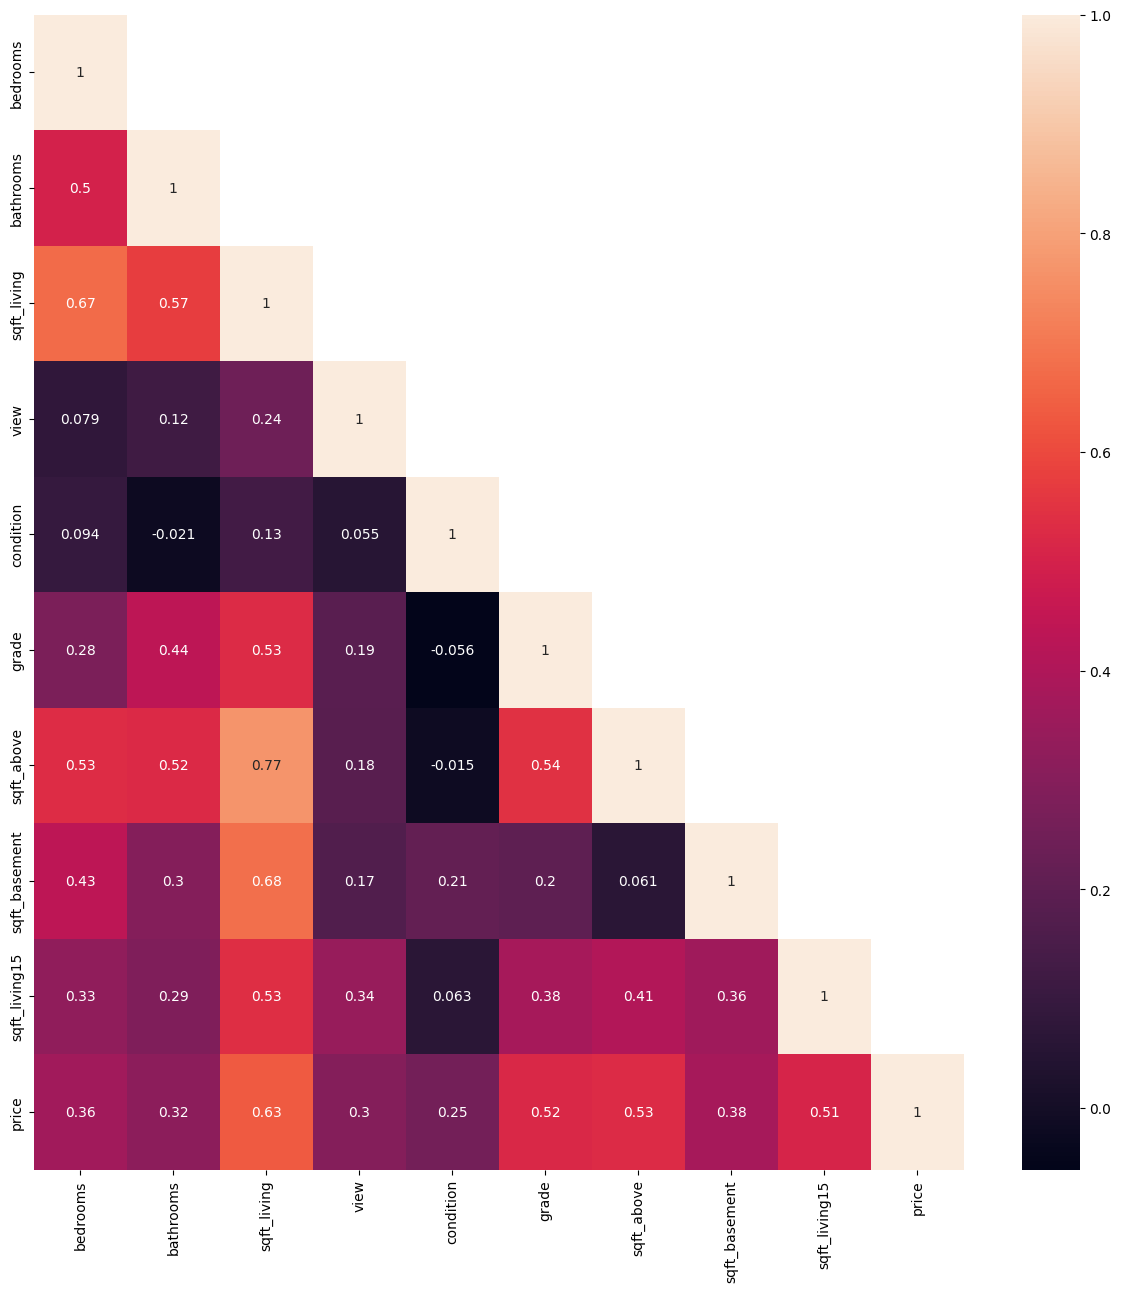

In [271]:
fig, ax = plt.subplots(figsize = (15,15))

mask = np.triu(np.ones_like(df_kc_target_corr, dtype=bool), k=1)

sns.heatmap(df_kc_target_corr, annot=True, mask=mask)

In [272]:
df_kc_target["condition"].value_counts()

condition
3    1716
4     550
5     271
2      40
1       3
Name: count, dtype: int64

In [273]:
df_kc_target["grade"].value_counts()

grade
7     1390
8      532
6      528
9       92
5       28
10       6
4        3
11       1
Name: count, dtype: int64

In [274]:
df_kc_target[df_kc_target["yr_renovated"] > 2010]["grade"].value_counts()

grade
7    13
8     8
6     3
9     1
Name: count, dtype: int64

In [275]:
df_kc_target[df_kc_target["yr_renovated"] > 2010]["condition"].value_counts()

condition
3    24
5     1
Name: count, dtype: int64

In [276]:
# Renovated flats seem to have grade = 3; condition = 7

<Axes: xlabel='grade', ylabel='price'>

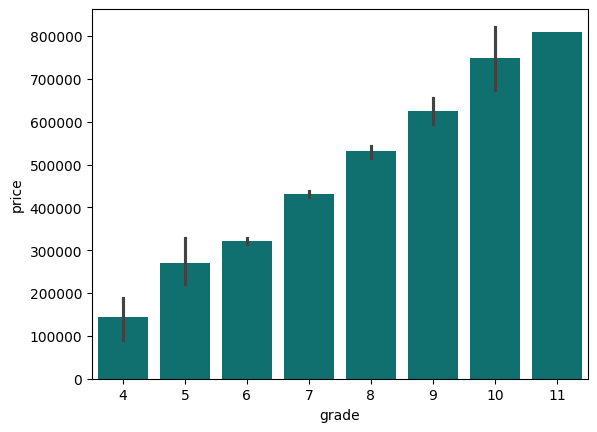

In [277]:
sns.barplot(df_kc_target, x = df_kc_target["grade"], y = df_kc_target["price"], color ="teal")

<Axes: xlabel='grade', ylabel='Count'>

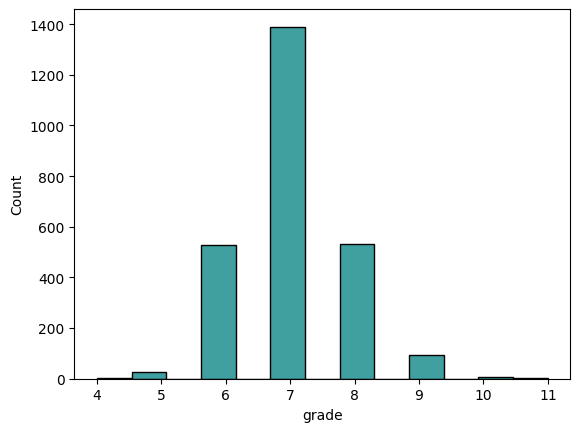

In [278]:
sns.histplot(df_kc_target["grade"], color="teal", shrink=1)

<Axes: xlabel='condition', ylabel='price'>

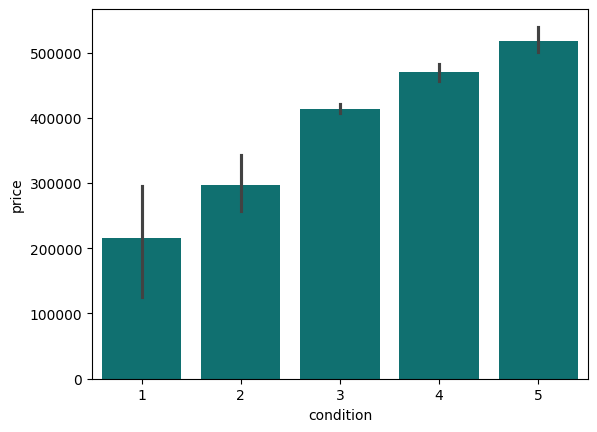

In [279]:
sns.barplot(df_kc_target, x = df_kc_target["condition"], y = df_kc_target["price"], color ="teal")

<Axes: xlabel='condition', ylabel='Count'>

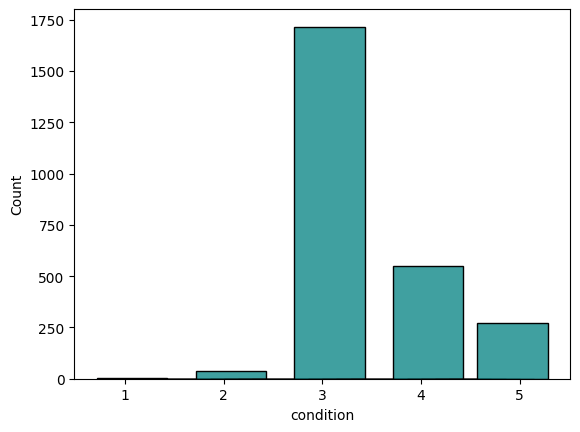

In [280]:
sns.histplot(df_kc_target["condition"], color="teal", shrink=5)

In [281]:
## Due to lack of proper data distribution, I get rid of the condition feature
df_kc_target = df_kc_target.drop("condition", axis = 1)

In [282]:
df_kc_target_pairplot = df_kc_target[['bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade', 'sqft_above', 'sqft_basement',  'sqft_living15',  'price']]

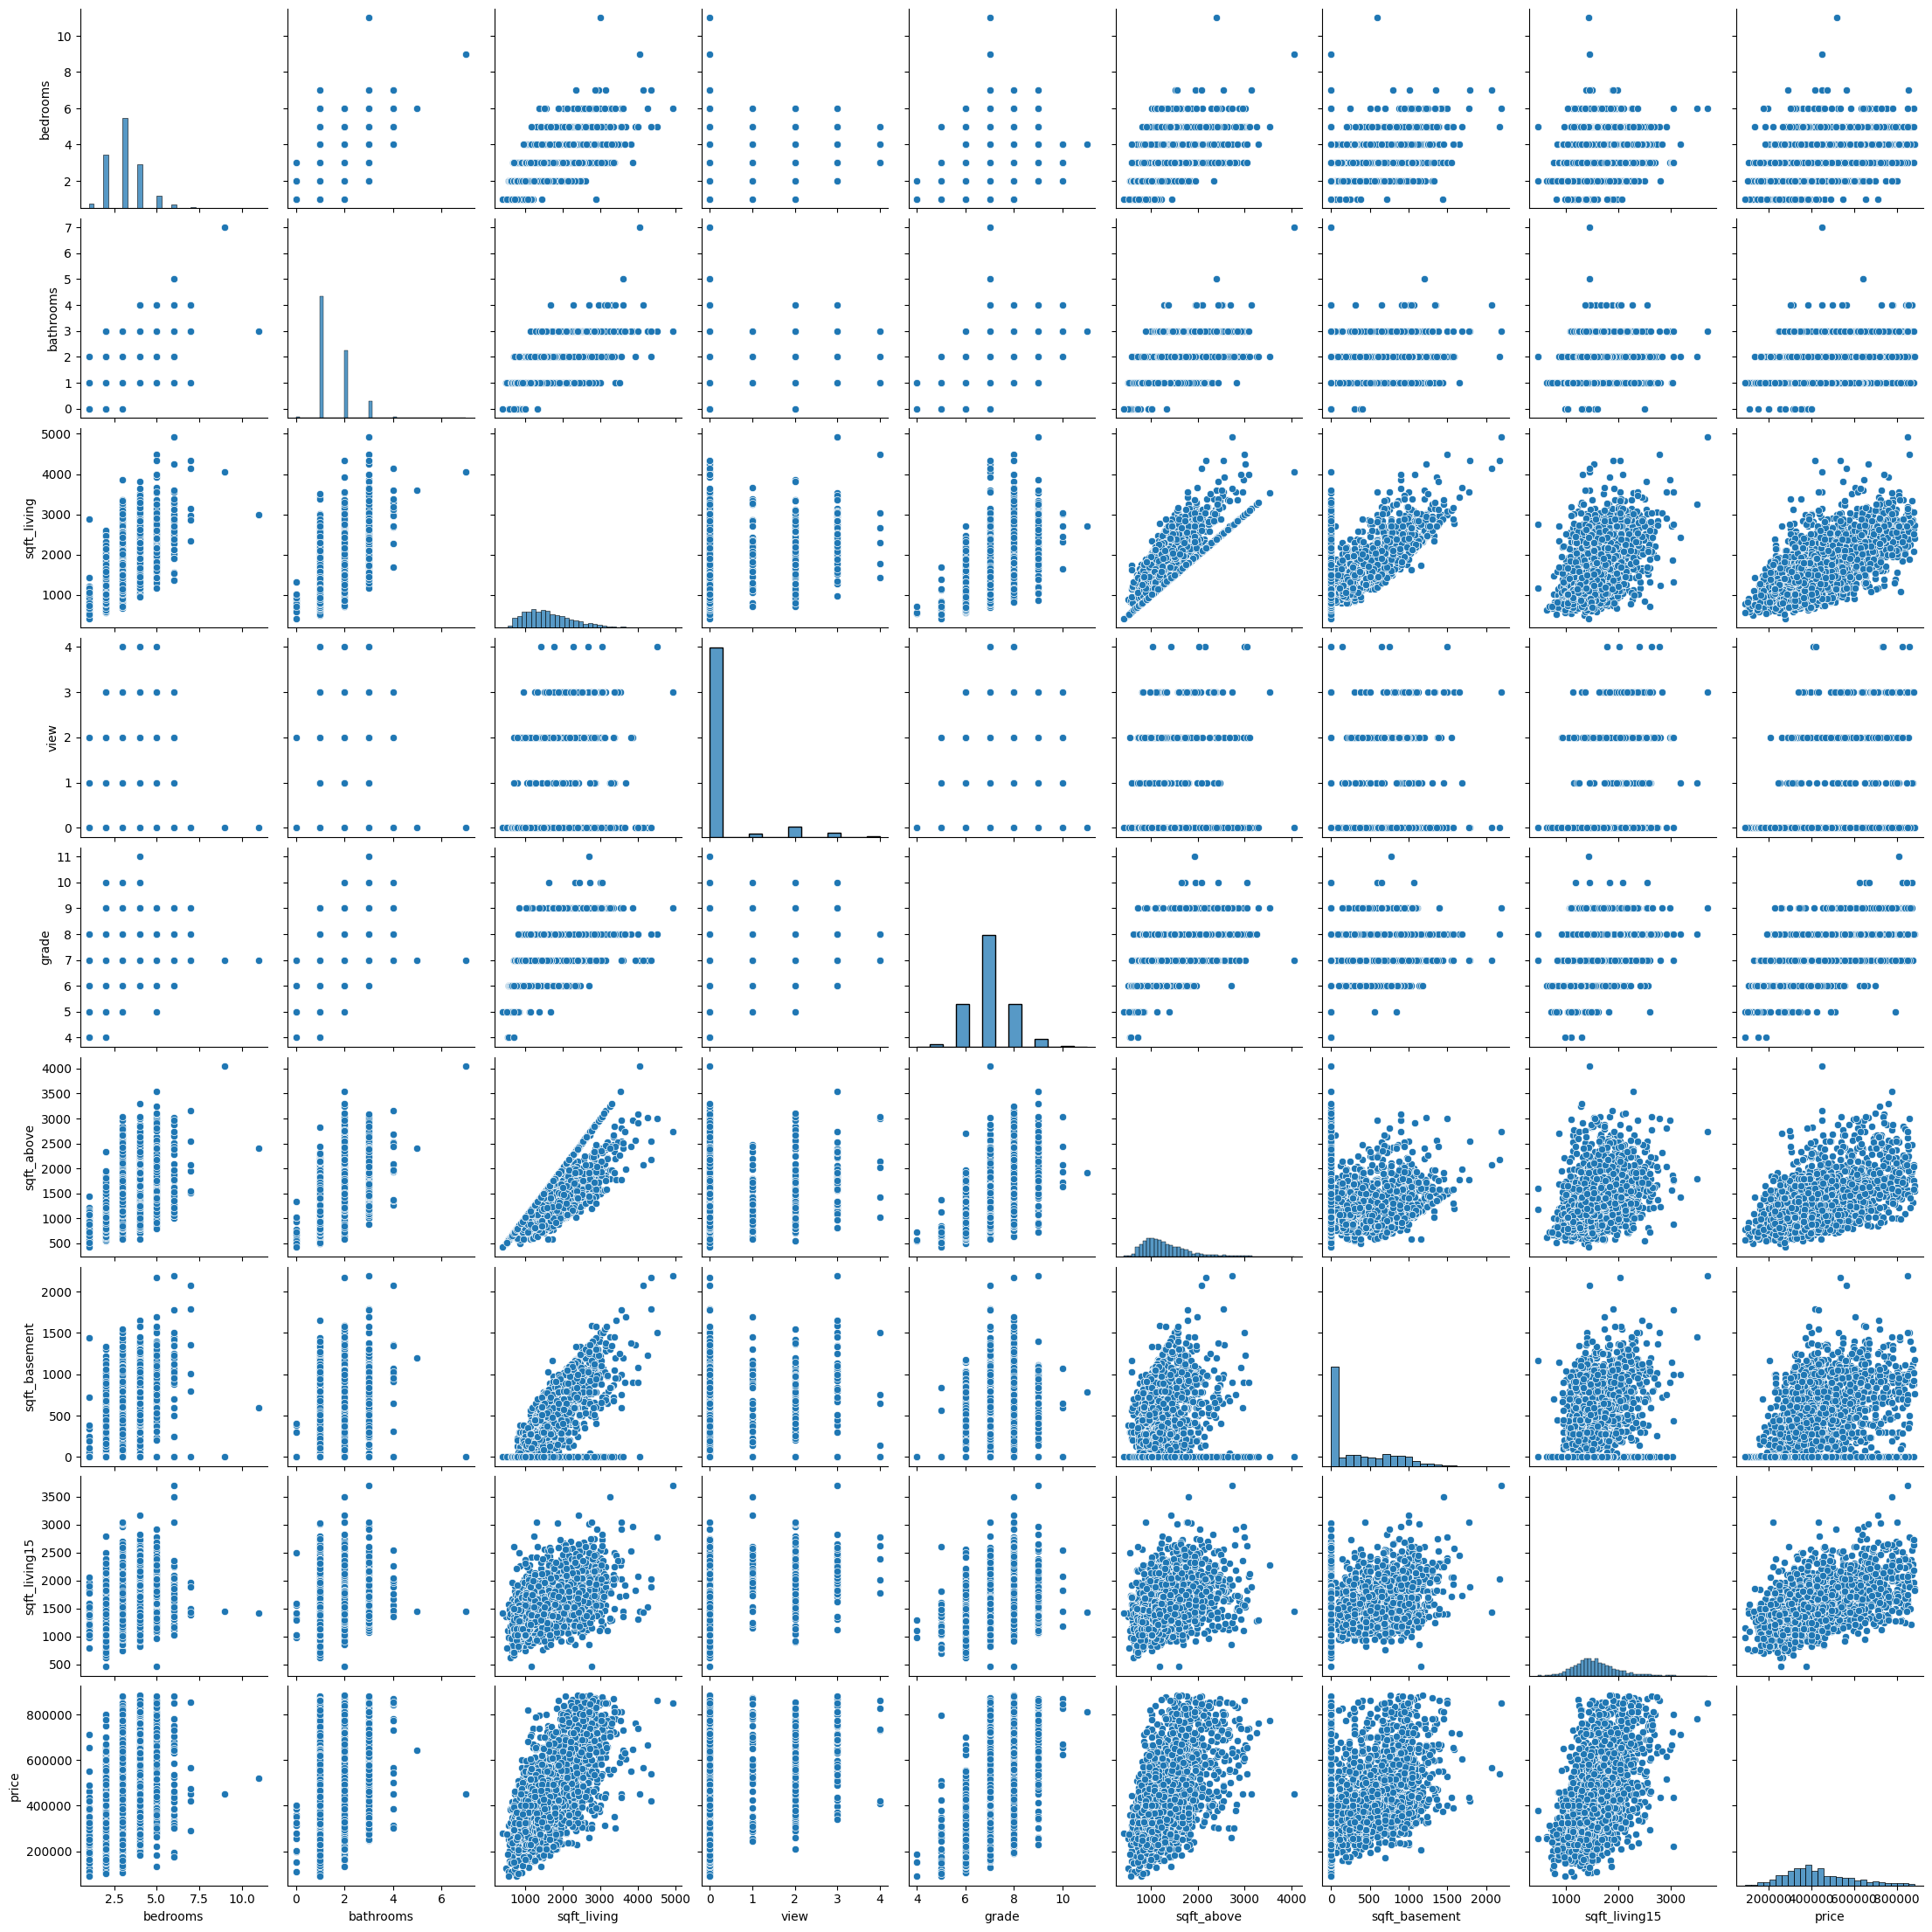

In [287]:
sns.pairplot(df_kc_target_pairplot)

In [286]:
# we leave the view out, as it doesnt influence that much on price, and distribution is not good

df_kc_target = df_kc_target.drop("view", axis=1)

# Evaluate potential houses without renovation

In [288]:
df_kc_target_potential = df_kc_target.query("yr_renovated == 0")

In [289]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 1 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   house_id       2580 non-null   int64         
 1   date           2580 non-null   datetime64[ns]
 2   price          2580 non-null   float64       
 3   bedrooms       2580 non-null   int64         
 4   bathrooms      2580 non-null   int64         
 5   sqft_living    2580 non-null   float64       
 6   grade          2580 non-null   int64         
 7   sqft_above     2580 non-null   float64       
 8   sqft_basement  2580 non-null   int64         
 9   zipcode        2580 non-null   int64         
 10  lat            2580 non-null   float64       
 11  long           2580 non-null   float64       
 12  sqft_living15  2580 non-null   float64       
 13  yr_renovated   2580 non-null   int64         
 14  price_range    2580 non-null   category      
dtypes: category(1), datetime6

In [291]:
df_kc_potential_pairplot = df_kc_target_potential[['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement',  'sqft_living15',  'price']]

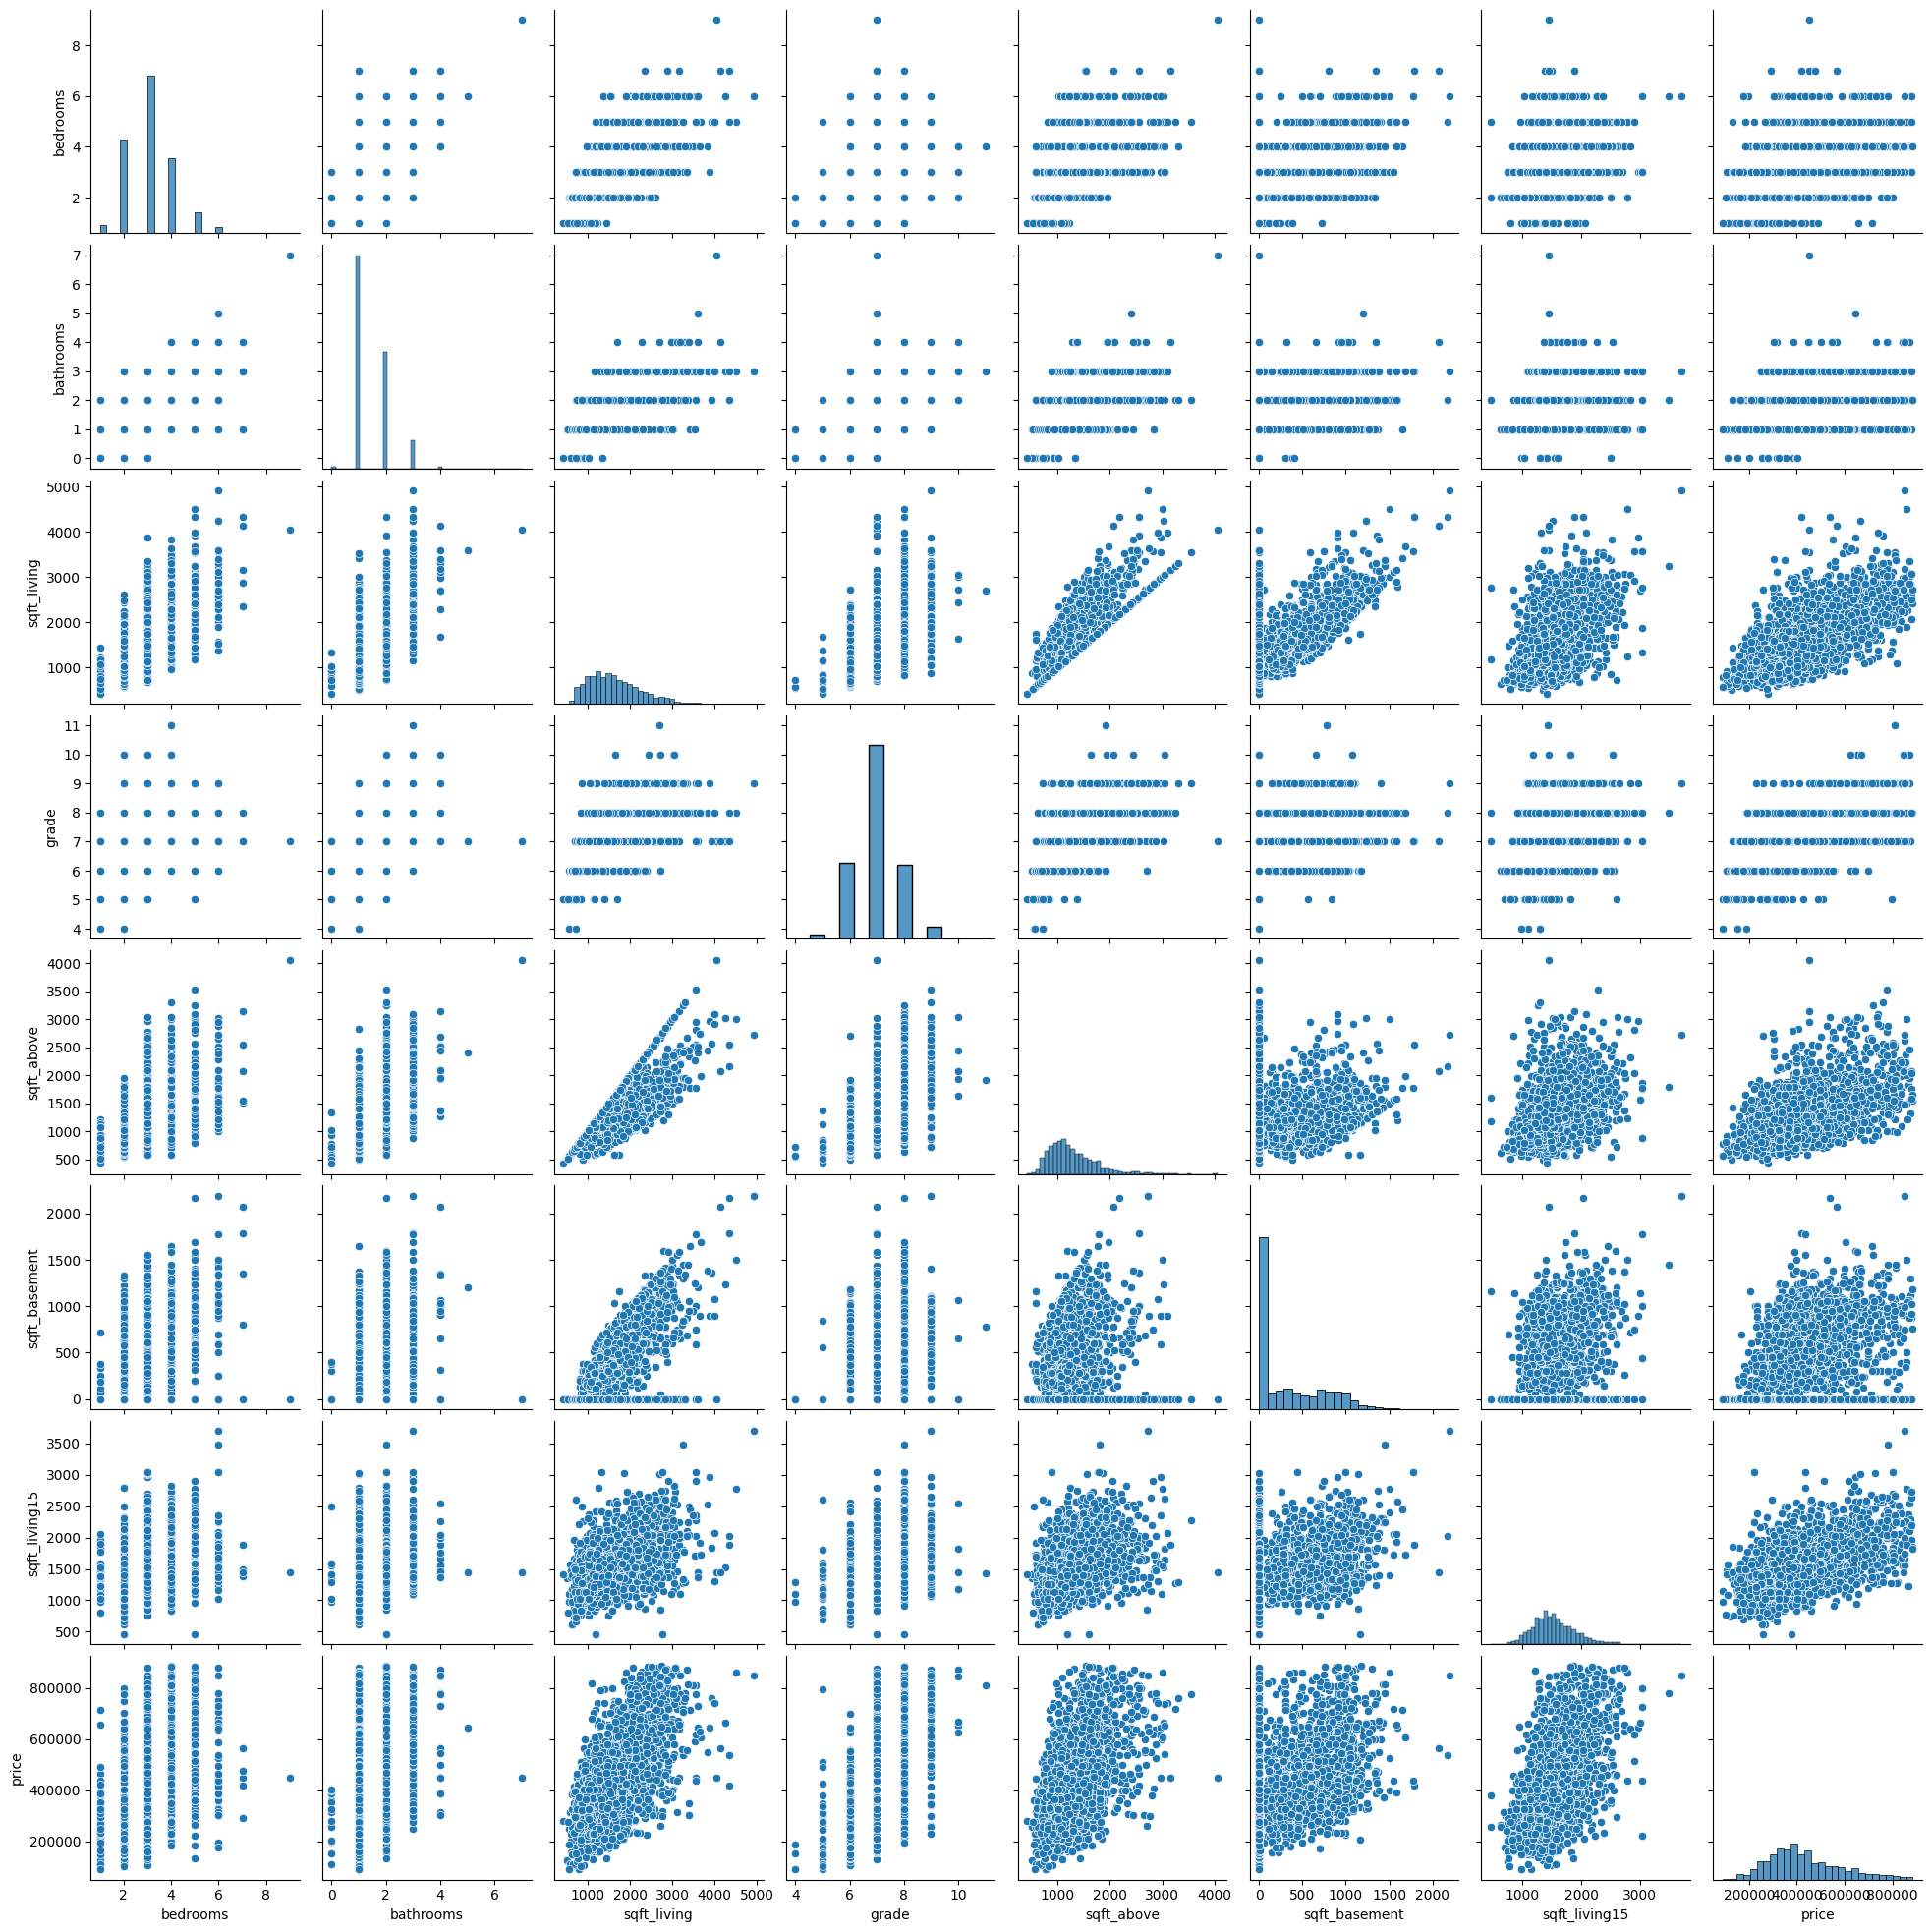

In [293]:
sns.pairplot(df_kc_potential_pairplot)

In [ ]:
df_kc_target = df_kc_target.drop(["sqft_lot", ], axis = 1)

# Next Section

In [27]:
fig = px.scatter_mapbox(df_kc_target, 
                        lat="lat", 
                        lon="long", 
                        color= "price_range",  # Color by price range
                        hover_name= "price",  # Show price in hover info
                        color_discrete_sequence=["blue", "green", "orange", "red"], 
                        title="House Prices in King County", 
                        mapbox_style= "carto-positron", 
                        zoom=10)

# Show the plot
fig.show()

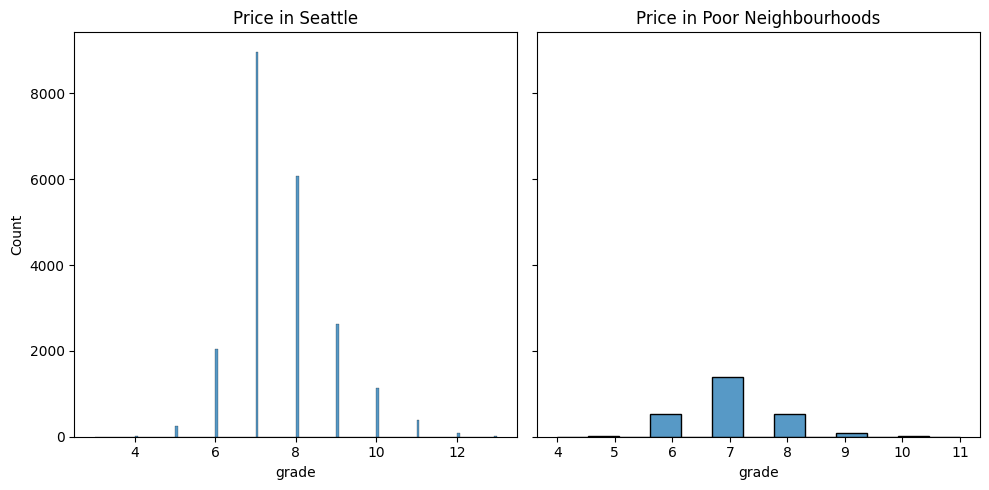

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(df_kc_data["grade"], ax=ax[0])

sns.histplot(df_kc_target["grade"], ax=ax[1])

ax[0].set_title('Price in Seattle')
ax[1].set_title('Price in Poor Neighbourhoods')

plt.tight_layout() 
plt.show()


#lower grades are more common in poor neighbourhoods

<Axes: xlabel='price', ylabel='yr_renovated'>

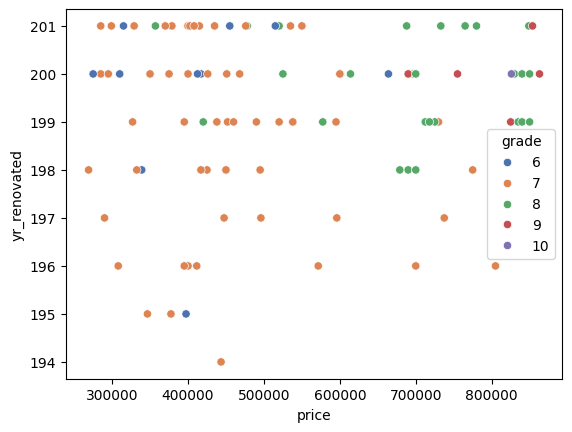

In [29]:
sns.scatterplot(df_kc_target.query("yr_renovated > 0"), x="price", y="yr_renovated", hue="grade", palette="deep" )

<Axes: xlabel='yr_built', ylabel='price'>

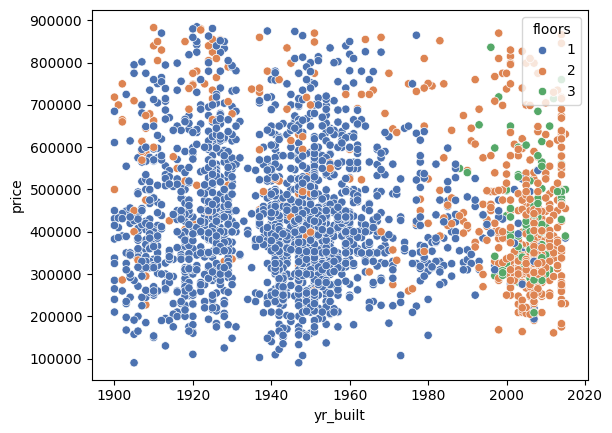

In [30]:
sns.scatterplot(df_kc_target, y="price", x="yr_built", hue="floors", palette="deep" )

<Axes: xlabel='condition', ylabel='Count'>

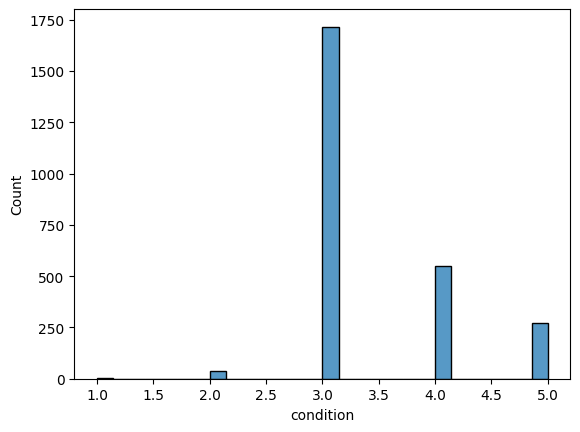

In [31]:
sns.histplot(df_kc_target["condition"])

In [32]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   house_id       2580 non-null   int64         
 1   date           2580 non-null   datetime64[ns]
 2   price          2580 non-null   float64       
 3   bedrooms       2580 non-null   int64         
 4   bathrooms      2580 non-null   int64         
 5   sqft_living    2580 non-null   float64       
 6   sqft_lot       2580 non-null   float64       
 7   floors         2580 non-null   int64         
 8   waterfront     2580 non-null   int64         
 9   view           2580 non-null   int64         
 10  condition      2580 non-null   int64         
 11  grade          2580 non-null   int64         
 12  sqft_above     2580 non-null   float64       
 13  sqft_basement  2580 non-null   int64         
 14  yr_built       2580 non-null   int64         
 15  yr_renovated   2580 non-n

In [99]:
df_kc_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2717 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   house_id       2717 non-null   int64   
 1   date           2717 non-null   object  
 2   price          2717 non-null   float64 
 3   bedrooms       2717 non-null   float64 
 4   bathrooms      2717 non-null   float64 
 5   sqft_living    2717 non-null   float64 
 6   sqft_lot       2717 non-null   float64 
 7   floors         2717 non-null   float64 
 8   waterfront     2406 non-null   float64 
 9   view           2707 non-null   float64 
 10  condition      2717 non-null   int64   
 11  grade          2717 non-null   int64   
 12  sqft_above     2717 non-null   float64 
 13  sqft_basement  2661 non-null   float64 
 14  yr_built       2717 non-null   int64   
 15  yr_renovated   2205 non-null   float64 
 16  zipcode        2717 non-null   int64   
 17  lat            2717 non-null   float6